## Using RNNs to add two binary strings ##

In this first lab, to get familiar with RNNs, we will explore the simple problem of teaching an RNN to add binary strings. Recall, like grade-school addition, binary addition moves from the right-most bit (least-significant bit or LSB) towards the left-most bit (most-significant) bit, with a carry bit passed from the previous addition.

Following is the "truth table" for a "full-adder" (i.e., carry-in, carry-out):

     i1   i2   carry-in  |  sum  carry-out
     --------------------+----------------
     0    0       0      |   0      0
     0    0       1      |   1      0
     0    1       0      |   1      0
     0    1       1      |   0      1
     1    0       0      |   1      0
     1    0       1      |   0      1
     1    1       0      |   0      1
     1    1       1      |   1      1

where, `i1` and `i2` are the input bits

The RNN is fed two bit-sequences and the target "sum" sequence.
The sequence is ordered from LSB to MSB, i.e., time-step 1 (t=1) corresponds to LSB, and the last time-step is the MSB.

For example:
If the bit strings 010 (integer value = 2) and 011 (integer value = 3) are to be added to produce the sum 101 (integer value 5), the following is the sequence of inputs and targets to the RNN when training:

    time | i1  i2 | output
    -----+--------+--------
     1   | 0    1 |   1
     2   | 1    1 |   0
     3   | 0    0 |   1

Note, in the example above, the "carry" bit is not explicitly provided as the input, and the RNN has to *learn* the concept of a carry-bit

### Overview ###
We will be using [PyTorch](http://pytorch.org) for implementation.

This question is planned as below:

    1. First we discuss how the training samples are generated
    2. Next, the we discuss the input and output format used for the RNN
    3. We set up the RNN network 
    4. We explore the effects of various parameters.

In [3]:
# coding: utf-8
# =============================================================================
# Make a simple RNN learn binray addition 
# Binary string pairs and the sum is generated for a given #numBits

# ==============================================================================


%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
import random
import sys
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
random.seed( 10 ) # set the random seed (for reproducibility)

## Preparing the Training Data ##

###   Radom binary strings of required length as training data ###
The function `getSample` below takes a string-length `L` as input and returns a training sample to be fed to the RNN.


For a given length `L`, a training sample is a 2-tuple of (`input`, `output`), where

* `input` is a tensor of size [`L+1x2`]:<br>
	* The second dimension of 2, corresponds to 2 inputs which are
		to be summed together.
	* The first row is for LSBs, and the last row correspond to MSBs.
	* The bit-strings are `L+1` due to a possible carry when adding two `L`-length bit strings.

* `output` is a tensor of size `L+1`, which is the sum of the inputs

In [4]:
def getSample(stringLength, testFlag=False):
    """
    Returns a random sample for bit-string addition.
    STRINGLENGTH: (int scalar) (one less than) length of the bit-string to return.
    TESTFLAG: (boolean) if True, the returned sample is printed.
    
    Returns:
        a 2-tuple of (Input,Output), where:
        INPUT: (L+1 x 2) dimensional tensor of the inputs, where L==STRINGLENGTH
        OUTPUT: (L+1) dimensional "target" vector, which is the binary sum of inputs.
    """
    lowerBound=pow(2,stringLength-1)
    upperBound=pow(2,stringLength)-1
    
    num1=random.randint(lowerBound,upperBound)
    num2=random.randint(lowerBound,upperBound)

    num3=num1+num2
    num3Binary=(bin(num3)[2:])

    num1Binary=(bin(num1)[2:])
    num2Binary=(bin(num2)[2:])

    if testFlag==1:
        print('input numbers and their sum  are', num1, ' ', num2, ' ', num3)
        print ('binary strings are', num1Binary, ' ' , num2Binary, ' ' , num3Binary)
    len_num1= (len(num1Binary))

    len_num2= (len(num2Binary))
    len_num3= (len(num3Binary))

    # since num3 will be the largest, we pad  other numbers with zeros to that num3_len
    num1Binary= ('0'*(len(num3Binary)-len(num1Binary))+num1Binary)
    num2Binary= ('0'*(len(num3Binary)-len(num2Binary))+num2Binary)

    # forming the input sequence
    # the input at first timestep is the least significant bits of the two input binary strings
    # x will be then a len_num3 ( or T ) * 2 array
    x=torch.zeros(len_num3,2)
    #x=np.zeros((len_num3,2),dtype=np.float32)
    for i in range(0, len_num3):
        x[i,0]=int(num1Binary[len_num3-1-i]) # note that MSB of the binray string should be the last input along the time axis
        x[i,1]=int(num2Binary[len_num3-1-i])
    #y=np.zeros((len_num3,1),dtype=np.float32)
    y=torch.zeros(len_num3,1)
    for i in range(0,len_num3):
        y[i,0]=int(num3Binary[len_num3-1-i])
    
    # target vector is the sum in binary

    return x,y 

### Model Input ###
As noted above, the inputs are `L+1x2` dimensional tensors, with the first row corresponding to LSB and the last to MSB. As addition proceeds from LSB to MSB, the `input` rows are fed  one-by-one, starting from the top, proceeding all the way to the last row.<br>
__Note__: This is not shown explicitly in the provided code, but is done internally.


### Model Output  ###
At each time-step the model needs to predict the target "sum".


## Training Loss ##
We use the `Mean-Squared-Error` loss function to compare the predicted value $y_t$, and the target $\tilde{y_t}$:

$$\mathcal{L}_t(y_t,\tilde{y_t}) = \left(y_t - \tilde{y_t}\right)^2$$

__Note__: The total loss for a given sequence is the sum of all the losses from each time-step.


The image below shows a schematic of the "unrolled" RNN for binary-addition:


![static/network architecture](static/binAdd.png)


## Model Implementation ##
The following class `Adder` implements the above RNN. We only give the forward-pass implementation.
The backward pass is calcuated automatically by PyTorch's auto-grad.

The only parameters passed to the model is the size (dimensionality) of the hidden state.
Bigger state, means higher capacity.


In [7]:
class Adder (nn.Module):
    def __init__(self,stateDim):
        super(Adder, self).__init__()
        self.stateDim = stateDim
        self.inputDim = 2  # two for the two inputs
        self.outputDim = 1  # one for the "score"
        # currently the model uses the 'LSTM' cell. You could try
        # others like: tanh, GRU. See: https://github.com/pytorch/examples/blob/master/word_language_model/model.py#L11
        self.lstm = nn.LSTM(self.inputDim, self.stateDim )
        self.outputLayer = nn.Linear(self.stateDim, self.outputDim)

    def forward(self, x):
        """
        X: [L,B,inputDim(=2)] dimensional input tensor
            L: Sequence length
            B: is the "batch" dimension. As we are training on 
               single examples, B = 1 for us.
        """
        lstmOut,_ = self.lstm(x)
        L,B,D  = lstmOut.size(0),lstmOut.size(1),lstmOut.size(2)
        lstmOut = lstmOut.contiguous() 
        # before  feeding to linear layer we squash one dimension
        lstmOut = lstmOut.view(L*B,D)
        pred = F.sigmoid(self.outputLayer(lstmOut)) # project lstm states to "output"
        # reshape actiavtions to T*B*outputDim
        #squeeze ll remove the extra dummy dimension for B so pred would be 2D tensor
        pred = pred.view(L,B,-1).squeeze(1) 
        return pred

### Training the Network ###

The model is trained on bit-strings of length `stringLen` sampled randomly.

For simplicity, training code runs for a fixed number of epochs (or iterations). In practice, the training should be monitored with performance on a held-out or validation set, in order to avoid over-fitting.

We use the [`Adam` optimizer](https://arxiv.org/abs/1412.6980).

The model runs fast enough to train on the CPU itself (GPUs are not used).



In [8]:
# set here the size of the RNN state:
stateSize = 10
# set here the size of the binary strings to be used for training:
stringLen = 3

# create the model:
model = Adder(stateSize)
print ('Model initialized')

# create the loss-function:
lossFunction = nn.MSELoss() # or nn.CrossEntropyLoss() -- see question #2 below

# uncomment below to change the optimizers:
#optimizer = optim.SGD(model.parameters(), lr=3e-2, momentum=0.8)
optimizer = optim.Adam(model.parameters(),lr=0.01)
iterations = 500
min_epochs = 20
num_epochs,totalLoss = 0,float("inf")
while num_epochs < min_epochs:
    print("[epoch %d/%d] Avg. Loss for last 500 samples = %lf"%(num_epochs+1,min_epochs,totalLoss))
    num_epochs += 1
    totalLoss = 0
    for i in range(0,iterations):
        # get a new random training sample:
        x,y = getSample(stringLen)
        # zero the gradients from the previous time-step:
        model.zero_grad()
        #convert to torch tensor and variable:
        ## unsqueeze() is used to add the extra BATCH dimension:
        x=x.unsqueeze(1)
         
        seqLen = x.size(0)
        x = x.contiguous()
        
        # push the inputs through the RNN (this is the forward pass):
        pred = model(x)
        # compute the loss:
        loss = lossFunction(pred,y)
        totalLoss += loss.data[0]
        optimizer.zero_grad()
        # perform the backward pass:
        loss.backward()
        # update the weights:
        optimizer.step()
    totalLoss=totalLoss/iterations
print('Training finished!')

Model initialized
[epoch 1/20] Avg. Loss for last 500 samples = inf


/home/manisha.padala/env3/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/manisha.padala/env3/lib/python3.5/site-packages/ipykernel_launcher.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[epoch 2/20] Avg. Loss for last 500 samples = 0.122207
[epoch 3/20] Avg. Loss for last 500 samples = 0.022057
[epoch 4/20] Avg. Loss for last 500 samples = 0.012730
[epoch 5/20] Avg. Loss for last 500 samples = 0.001607
[epoch 6/20] Avg. Loss for last 500 samples = 0.000620
[epoch 7/20] Avg. Loss for last 500 samples = 0.000254
[epoch 8/20] Avg. Loss for last 500 samples = 0.000126
[epoch 9/20] Avg. Loss for last 500 samples = 0.000087
[epoch 10/20] Avg. Loss for last 500 samples = 0.000061
[epoch 11/20] Avg. Loss for last 500 samples = 0.000044
[epoch 12/20] Avg. Loss for last 500 samples = 0.000029
[epoch 13/20] Avg. Loss for last 500 samples = 0.000021
[epoch 14/20] Avg. Loss for last 500 samples = 0.000016
[epoch 15/20] Avg. Loss for last 500 samples = 0.000012
[epoch 16/20] Avg. Loss for last 500 samples = 0.000009
[epoch 17/20] Avg. Loss for last 500 samples = 0.000007
[epoch 18/20] Avg. Loss for last 500 samples = 0.000005
[epoch 19/20] Avg. Loss for last 500 samples = 0.000004


### Testing the model ###
We now test the trained model. We get random inputs again (as before),
push them through the RNN, getting a prediction (in the [0,1] range due to the sigmoid) at every time step.
We discretize the output to 0 or 1, by thresholding at 0.5.

In [9]:
def test_by_length(stringLen,n_samples=100,verbose=True):
    n_samples = min(n_samples,2**stringLen)
    total_correctBits, total_num_bits = 0,0
    for i in range(n_samples):
        x,y = getSample(stringLen,testFlag=verbose)
        x=x.unsqueeze(1)
        seqLen = x.size(0)
        x = x.contiguous()
        finalScores = model(x).data.t().numpy()
        #print(finalScores.shape)
        # to get the final predictions, threshold the output of RNN at 0.5:
        ## this needs to be changed when you switch to cross-entropy loss (see question #2).
        bits = (finalScores > 0.5).astype(np.int32)
        
        y_pred = bits[0,:]
        y_pred = np.transpose(y_pred) #change to row vector
        y_pred_flipped = np.flip(y_pred,0) # reverse the array
        #print(y_pred)
        #print(y)
        
        
        #print ('shape of y_pred is',y_pred.shape)
        #print ('shape of y is',y.size())
        #print ('length of y is', len(y))
        fullStringCorr=1
        bitsCorrectInCurrentSample=0
        # iterate through each bit position and check if the corresponding bits are same
        # TODO - could be done in a better fashion
        for i in range (0,len(y)):
            if  y_pred[i]!=int(y[i,0]):
             
                fullStringCorr=0
            else:
                bitsCorrectInCurrentSample+=1
                total_correctBits+=1
        
        
        total_num_bits += len(y)
        if verbose:
            print('sum predicted by RNN is ',y_pred_flipped)
            print('bit-accuracy : %s'%(bitsCorrectInCurrentSample/(len(y)+0.0)))
            print(40*'*')
    accuracy = total_correctBits / (total_num_bits + 0.0)
    if verbose:
        print(40*'*')
        print('Final bit-accuracy for strings of length %d = %.3f'%(stringLen,accuracy))
        print(40*'*')
    return accuracy

## Testing Model Generalization Ability##
Recall that the model was trained on bit-strings of length 3.
We will now test the trained model on bit-strings of different lengths (other than 3):<br>
We will sweep the length-range from 2 to 20, and plot the bit-accuracy.


input numbers and their sum  are 2   3   5
binary strings are 10   11   101
sum predicted by RNN is  [1 0 1]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 3   3   6
binary strings are 11   11   110
sum predicted by RNN is  [1 1 0]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 2   2   4
binary strings are 10   10   100
sum predicted by RNN is  [1 0 0]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 2   2   4
binary strings are 10   10   100
sum predicted by RNN is  [1 0 0]
bit-accuracy : 1.0
****************************************
****************************************
Final bit-accuracy for strings of length 2 = 1.000
****************************************
input numbers and their sum  are 5   4   9
binary strings are 101   100   1001
sum predicted by RNN is  [1 0 0 1]
bit-accuracy : 1.0
****************************************
input numbers and

sum predicted by RNN is  [1 1 1 0 0 1]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 24   22   46
binary strings are 11000   10110   101110
sum predicted by RNN is  [1 0 1 1 1 0]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 21   27   48
binary strings are 10101   11011   110000
sum predicted by RNN is  [1 0 1 1 0 0]
bit-accuracy : 0.5
****************************************
input numbers and their sum  are 21   16   37
binary strings are 10101   10000   100101
sum predicted by RNN is  [1 0 0 1 0 1]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 22   28   50
binary strings are 10110   11100   110010
sum predicted by RNN is  [1 1 0 0 1 0]
bit-accuracy : 1.0
****************************************
****************************************
Final bit-accuracy for strings of length 5 = 0.932
****************************************
input numbers and th

sum predicted by RNN is  [1 0 0 0 1 0 1]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 40   45   85
binary strings are 101000   101101   1010101
sum predicted by RNN is  [1 0 1 0 1 0 1]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 55   42   97
binary strings are 110111   101010   1100001
sum predicted by RNN is  [1 0 1 1 0 0 1]
bit-accuracy : 0.5714285714285714
****************************************
input numbers and their sum  are 46   58   104
binary strings are 101110   111010   1101000
sum predicted by RNN is  [1 0 1 1 0 0 0]
bit-accuracy : 0.7142857142857143
****************************************
input numbers and their sum  are 61   34   95
binary strings are 111101   100010   1011111
sum predicted by RNN is  [1 0 1 1 1 1 1]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 41   50   91
binary strings are 101001   110010   1011011
sum predi

sum predicted by RNN is  [1 0 1 1 0 1 1 1]
bit-accuracy : 0.875
****************************************
input numbers and their sum  are 75   112   187
binary strings are 1001011   1110000   10111011
sum predicted by RNN is  [1 1 1 1 1 0 1 1]
bit-accuracy : 0.875
****************************************
input numbers and their sum  are 65   88   153
binary strings are 1000001   1011000   10011001
sum predicted by RNN is  [1 0 1 1 1 0 0 1]
bit-accuracy : 0.875
****************************************
input numbers and their sum  are 80   105   185
binary strings are 1010000   1101001   10111001
sum predicted by RNN is  [1 0 1 1 1 0 0 1]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 122   64   186
binary strings are 1111010   1000000   10111010
sum predicted by RNN is  [1 0 1 1 1 0 1 0]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 101   107   208
binary strings are 1100101   1101011   11010000

sum predicted by RNN is  [1 0 0 0 1 0 0 1]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 96   86   182
binary strings are 1100000   1010110   10110110
sum predicted by RNN is  [1 0 1 1 0 1 1 0]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 106   97   203
binary strings are 1101010   1100001   11001011
sum predicted by RNN is  [1 1 0 0 1 0 1 1]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 114   80   194
binary strings are 1110010   1010000   11000010
sum predicted by RNN is  [1 1 1 0 0 0 1 0]
bit-accuracy : 0.875
****************************************
input numbers and their sum  are 97   108   205
binary strings are 1100001   1101100   11001101
sum predicted by RNN is  [1 1 0 1 1 1 0 1]
bit-accuracy : 0.875
****************************************
input numbers and their sum  are 95   94   189
binary strings are 1011111   1011110   10111101
sum

sum predicted by RNN is  [1 0 1 1 1 1 0 0 0]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 131   187   318
binary strings are 10000011   10111011   100111110
sum predicted by RNN is  [1 0 0 1 1 1 1 1 0]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 138   152   290
binary strings are 10001010   10011000   100100010
sum predicted by RNN is  [1 0 0 1 1 0 0 1 0]
bit-accuracy : 0.8888888888888888
****************************************
input numbers and their sum  are 230   236   466
binary strings are 11100110   11101100   111010010
sum predicted by RNN is  [1 1 1 0 1 0 0 1 0]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 138   242   380
binary strings are 10001010   11110010   101111100
sum predicted by RNN is  [1 1 1 1 1 1 1 0 0]
bit-accuracy : 0.8888888888888888
****************************************
input numbers and their sum  are 177   169   

sum predicted by RNN is  [1 0 1 1 0 1 1 1 0]
bit-accuracy : 0.7777777777777778
****************************************
input numbers and their sum  are 138   207   345
binary strings are 10001010   11001111   101011001
sum predicted by RNN is  [1 0 1 1 1 1 0 0 1]
bit-accuracy : 0.8888888888888888
****************************************
input numbers and their sum  are 150   195   345
binary strings are 10010110   11000011   101011001
sum predicted by RNN is  [1 0 1 0 1 1 0 0 1]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 215   241   456
binary strings are 11010111   11110001   111001000
sum predicted by RNN is  [1 1 1 1 0 0 1 0 0]
bit-accuracy : 0.6666666666666666
****************************************
input numbers and their sum  are 226   224   450
binary strings are 11100010   11100000   111000010
sum predicted by RNN is  [1 1 1 0 0 0 0 1 0]
bit-accuracy : 1.0
****************************************
input numbers and their sum  a

sum predicted by RNN is  [1 0 1 1 0 1 1 0 1 0]
bit-accuracy : 0.6
****************************************
input numbers and their sum  are 258   427   685
binary strings are 100000010   110101011   1010101101
sum predicted by RNN is  [1 0 1 0 1 0 1 1 0 1]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 480   382   862
binary strings are 111100000   101111110   1101011110
sum predicted by RNN is  [1 0 1 1 1 1 1 1 1 0]
bit-accuracy : 0.7
****************************************
input numbers and their sum  are 256   463   719
binary strings are 100000000   111001111   1011001111
sum predicted by RNN is  [1 0 1 1 0 1 1 1 1 1]
bit-accuracy : 0.9
****************************************
input numbers and their sum  are 488   411   899
binary strings are 111101000   110011011   1110000011
sum predicted by RNN is  [1 1 0 1 1 1 0 0 1 1]
bit-accuracy : 0.6
****************************************
input numbers and their sum  are 271   387   658
bina

sum predicted by RNN is  [1 1 1 0 0 1 1 1 0 1]
bit-accuracy : 0.6
****************************************
input numbers and their sum  are 483   493   976
binary strings are 111100011   111101101   1111010000
sum predicted by RNN is  [1 1 1 1 0 0 1 1 0 0]
bit-accuracy : 0.7
****************************************
input numbers and their sum  are 485   507   992
binary strings are 111100101   111111011   1111100000
sum predicted by RNN is  [1 1 1 1 0 1 1 1 0 0]
bit-accuracy : 0.6
****************************************
input numbers and their sum  are 485   352   837
binary strings are 111100101   101100000   1101000101
sum predicted by RNN is  [1 0 1 1 0 0 0 1 0 1]
bit-accuracy : 0.8
****************************************
input numbers and their sum  are 421   301   722
binary strings are 110100101   100101101   1011010010
sum predicted by RNN is  [1 0 1 1 0 1 0 0 1 0]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 366   434   800
bina

sum predicted by RNN is  [1 1 1 0 0 1 1 0 1 1 1]
bit-accuracy : 0.6363636363636364
****************************************
input numbers and their sum  are 735   1005   1740
binary strings are 1011011111   1111101101   11011001100
sum predicted by RNN is  [1 1 1 1 0 1 1 1 1 0 0]
bit-accuracy : 0.6363636363636364
****************************************
input numbers and their sum  are 903   763   1666
binary strings are 1110000111   1011111011   11010000010
sum predicted by RNN is  [1 1 1 1 1 1 1 1 1 1 0]
bit-accuracy : 0.45454545454545453
****************************************
input numbers and their sum  are 876   687   1563
binary strings are 1101101100   1010101111   11000011011
sum predicted by RNN is  [1 0 1 1 1 1 1 1 0 1 1]
bit-accuracy : 0.5454545454545454
****************************************
input numbers and their sum  are 942   937   1879
binary strings are 1110101110   1110101001   11101010111
sum predicted by RNN is  [1 1 1 0 1 0 1 0 1 1 1]
bit-accuracy : 1.0
******

sum predicted by RNN is  [1 0 1 1 1 1 0 0 0 1 0]
bit-accuracy : 0.8181818181818182
****************************************
input numbers and their sum  are 1013   938   1951
binary strings are 1111110101   1110101010   11110011111
sum predicted by RNN is  [1 1 1 1 1 0 1 1 1 1 1]
bit-accuracy : 0.9090909090909091
****************************************
input numbers and their sum  are 576   978   1554
binary strings are 1001000000   1111010010   11000010010
sum predicted by RNN is  [1 0 1 1 0 1 1 0 0 1 0]
bit-accuracy : 0.6363636363636364
****************************************
input numbers and their sum  are 779   1008   1787
binary strings are 1100001011   1111110000   11011111011
sum predicted by RNN is  [1 1 1 1 1 1 1 1 0 1 1]
bit-accuracy : 0.9090909090909091
****************************************
input numbers and their sum  are 679   523   1202
binary strings are 1010100111   1000001011   10010110010
sum predicted by RNN is  [1 0 0 1 0 1 0 1 1 1 0]
bit-accuracy : 0.72727272

sum predicted by RNN is  [1 0 0 0 1 1 1 1 0 0 1]
bit-accuracy : 0.6363636363636364
****************************************
input numbers and their sum  are 834   690   1524
binary strings are 1101000010   1010110010   10111110100
sum predicted by RNN is  [1 0 1 1 1 1 1 0 1 0 0]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 1001   677   1678
binary strings are 1111101001   1010100101   11010001110
sum predicted by RNN is  [1 0 1 1 1 0 0 1 1 1 0]
bit-accuracy : 0.7272727272727273
****************************************
****************************************
Final bit-accuracy for strings of length 10 = 0.798
****************************************
input numbers and their sum  are 1614   1174   2788
binary strings are 11001001110   10010010110   101011100100
sum predicted by RNN is  [1 0 1 0 1 1 0 1 1 1 0 0]
bit-accuracy : 0.75
****************************************
input numbers and their sum  are 1806   1049   2855
binary strings are

sum predicted by RNN is  [1 1 1 1 0 1 1 1 0 1 0 0]
bit-accuracy : 0.5833333333333334
****************************************
input numbers and their sum  are 1935   1903   3838
binary strings are 11110001111   11101101111   111011111110
sum predicted by RNN is  [1 1 1 0 1 1 1 1 1 1 1 0]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 1561   1029   2590
binary strings are 11000011001   10000000101   101000011110
sum predicted by RNN is  [1 0 1 0 0 0 0 1 1 1 1 0]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 1024   1478   2502
binary strings are 10000000000   10111000110   100111000110
sum predicted by RNN is  [1 0 1 1 1 1 0 0 0 1 1 0]
bit-accuracy : 0.9166666666666666
****************************************
input numbers and their sum  are 1413   1487   2900
binary strings are 10110000101   10111001111   101101010100
sum predicted by RNN is  [1 1 1 1 0 1 0 1 1 1 0 0]
bit-accuracy : 0.8333333333

sum predicted by RNN is  [1 0 1 1 0 1 1 1 1 1 1 0]
bit-accuracy : 0.5
****************************************
input numbers and their sum  are 1307   1363   2670
binary strings are 10100011011   10101010011   101001101110
sum predicted by RNN is  [1 0 1 0 0 1 1 0 1 1 1 0]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 1885   1108   2993
binary strings are 11101011101   10001010100   101110110001
sum predicted by RNN is  [1 0 1 1 0 1 1 1 0 0 0 1]
bit-accuracy : 0.8333333333333334
****************************************
input numbers and their sum  are 1290   1489   2779
binary strings are 10100001010   10111010001   101011011011
sum predicted by RNN is  [1 1 1 0 1 1 0 1 1 0 1 1]
bit-accuracy : 0.9166666666666666
****************************************
input numbers and their sum  are 1351   1970   3321
binary strings are 10101000111   11110110010   110011111001
sum predicted by RNN is  [1 1 1 0 1 1 1 1 1 0 0 1]
bit-accuracy : 0.9166666666

sum predicted by RNN is  [1 0 0 1 1 1 1 1 1 0 1 1 0]
bit-accuracy : 0.6923076923076923
****************************************
input numbers and their sum  are 3152   2313   5465
binary strings are 110001010000   100100001001   1010101011001
sum predicted by RNN is  [1 0 1 1 1 0 1 0 1 1 0 0 1]
bit-accuracy : 0.9230769230769231
****************************************
input numbers and their sum  are 3563   2434   5997
binary strings are 110111101011   100110000010   1011101101101
sum predicted by RNN is  [1 1 1 1 1 0 1 1 0 1 1 0 1]
bit-accuracy : 0.9230769230769231
****************************************
input numbers and their sum  are 2947   2444   5391
binary strings are 101110000011   100110001100   1010100001111
sum predicted by RNN is  [1 0 1 1 1 0 0 0 1 1 1 1 1]
bit-accuracy : 0.8461538461538461
****************************************
input numbers and their sum  are 2138   3699   5837
binary strings are 100001011010   111001110011   1011011001101
sum predicted by RNN is  [1 

sum predicted by RNN is  [1 0 0 1 1 0 0 1 1 1 1 1 0]
bit-accuracy : 0.7692307692307693
****************************************
input numbers and their sum  are 4025   3272   7297
binary strings are 111110111001   110011001000   1110010000001
sum predicted by RNN is  [1 1 0 1 1 0 1 1 1 0 0 0 1]
bit-accuracy : 0.46153846153846156
****************************************
input numbers and their sum  are 3947   2146   6093
binary strings are 111101101011   100001100010   1011111001101
sum predicted by RNN is  [1 0 1 1 1 1 1 0 0 1 1 0 1]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 3794   3462   7256
binary strings are 111011010010   110110000110   1110001011000
sum predicted by RNN is  [1 1 0 1 1 0 1 0 1 1 0 0 0]
bit-accuracy : 0.7692307692307693
****************************************
input numbers and their sum  are 3979   4014   7993
binary strings are 111110001011   111110101110   1111100111001
sum predicted by RNN is  [1 1 1 1 1 0 0 1 

sum predicted by RNN is  [1 1 1 0 1 1 1 0 0 1 0 1 0 0]
bit-accuracy : 0.7857142857142857
****************************************
input numbers and their sum  are 8120   6334   14454
binary strings are 1111110111000   1100010111110   11100001110110
sum predicted by RNN is  [1 1 0 1 1 1 1 1 1 1 0 1 1 0]
bit-accuracy : 0.6428571428571429
****************************************
input numbers and their sum  are 4836   5130   9966
binary strings are 1001011100100   1010000001010   10011011101110
sum predicted by RNN is  [1 0 1 1 1 0 1 1 1 0 1 1 1 0]
bit-accuracy : 0.9285714285714286
****************************************
input numbers and their sum  are 4708   7170   11878
binary strings are 1001001100100   1110000000010   10111001100110
sum predicted by RNN is  [1 1 1 1 1 0 0 1 1 0 0 1 1 0]
bit-accuracy : 0.9285714285714286
****************************************
input numbers and their sum  are 4833   6111   10944
binary strings are 1001011100001   1011111011111   10101011000000
sum p

sum predicted by RNN is  [1 0 1 1 0 1 1 1 1 1 0 1 0 0]
bit-accuracy : 0.42857142857142855
****************************************
input numbers and their sum  are 5012   6350   11362
binary strings are 1001110010100   1100011001110   10110001100010
sum predicted by RNN is  [1 0 1 0 1 1 0 1 0 1 0 0 1 0]
bit-accuracy : 0.6428571428571429
****************************************
input numbers and their sum  are 8180   7055   15235
binary strings are 1111111110100   1101110001111   11101110000011
sum predicted by RNN is  [1 1 1 1 1 1 0 1 1 1 0 0 1 1]
bit-accuracy : 0.6428571428571429
****************************************
input numbers and their sum  are 6027   6760   12787
binary strings are 1011110001011   1101001101000   11000111110011
sum predicted by RNN is  [1 0 1 1 0 1 1 1 1 1 0 0 1 1]
bit-accuracy : 0.7857142857142857
****************************************
input numbers and their sum  are 4677   5237   9914
binary strings are 1001001000101   1010001110101   10011010111010
sum 

sum predicted by RNN is  [1 0 1 1 0 1 1 1 0 0 1 0 1 0]
bit-accuracy : 0.5714285714285714
****************************************
input numbers and their sum  are 7636   4794   12430
binary strings are 1110111010100   1001010111010   11000010001110
sum predicted by RNN is  [1 0 1 1 1 1 0 1 1 0 1 1 1 0]
bit-accuracy : 0.42857142857142855
****************************************
input numbers and their sum  are 7132   4811   11943
binary strings are 1101111011100   1001011001011   10111010100111
sum predicted by RNN is  [1 0 1 1 1 1 0 1 1 1 0 1 1 1]
bit-accuracy : 0.7142857142857143
****************************************
input numbers and their sum  are 5700   5952   11652
binary strings are 1011001000100   1011101000000   10110110000100
sum predicted by RNN is  [1 1 1 1 0 1 1 0 0 0 0 1 0 0]
bit-accuracy : 0.9285714285714286
****************************************
input numbers and their sum  are 6925   5492   12417
binary strings are 1101100001101   1010101110100   11000010000001
sum

sum predicted by RNN is  [1 1 1 0 0 1 1 0 1 1 0 0 0 0 1]
bit-accuracy : 0.8666666666666667
****************************************
input numbers and their sum  are 14483   10194   24677
binary strings are 11100010010011   10011111010010   110000001100101
sum predicted by RNN is  [1 0 1 1 1 1 1 0 1 1 0 0 1 0 1]
bit-accuracy : 0.6
****************************************
input numbers and their sum  are 13816   15720   29536
binary strings are 11010111111000   11110101101000   111001101100000
sum predicted by RNN is  [1 1 1 1 1 1 0 1 1 1 1 0 0 0 0]
bit-accuracy : 0.6666666666666666
****************************************
input numbers and their sum  are 13612   14281   27893
binary strings are 11010100101100   11011111001001   110110011110101
sum predicted by RNN is  [1 1 1 1 1 1 0 1 1 1 1 0 1 0 1]
bit-accuracy : 0.8666666666666667
****************************************
input numbers and their sum  are 12135   9476   21611
binary strings are 10111101100111   10010100000100   10101000

sum predicted by RNN is  [1 0 0 1 1 1 0 0 1 1 1 1 0 1 1]
bit-accuracy : 0.6666666666666666
****************************************
input numbers and their sum  are 11852   11210   23062
binary strings are 10111001001100   10101111001010   101101000010110
sum predicted by RNN is  [1 1 1 1 1 0 1 1 0 1 1 0 1 1 0]
bit-accuracy : 0.6
****************************************
input numbers and their sum  are 9188   10846   20034
binary strings are 10001111100100   10101001011110   100111001000010
sum predicted by RNN is  [1 0 0 1 1 0 1 1 0 1 1 0 0 1 0]
bit-accuracy : 0.6
****************************************
input numbers and their sum  are 10271   8446   18717
binary strings are 10100000011111   10000011111110   100100100011101
sum predicted by RNN is  [1 0 0 1 0 0 0 1 1 1 1 1 1 0 1]
bit-accuracy : 0.7333333333333333
****************************************
input numbers and their sum  are 12234   9723   21957
binary strings are 10111111001010   10010111111011   101010111000101
sum predi

sum predicted by RNN is  [1 1 1 0 1 0 1 1 1 1 0 1 0 0 1]
bit-accuracy : 0.7333333333333333
****************************************
input numbers and their sum  are 10962   14996   25958
binary strings are 10101011010010   11101010010100   110010101100110
sum predicted by RNN is  [1 1 1 0 1 0 1 0 1 1 0 0 1 1 0]
bit-accuracy : 0.9333333333333333
****************************************
input numbers and their sum  are 11847   12846   24693
binary strings are 10111001000111   11001000101110   110000001110101
sum predicted by RNN is  [1 0 1 1 1 0 0 0 1 1 0 1 1 0 1]
bit-accuracy : 0.6
****************************************
input numbers and their sum  are 8730   15338   24068
binary strings are 10001000011010   11101111101010   101111000000100
sum predicted by RNN is  [1 0 1 1 1 1 1 1 1 1 1 0 1 0 0]
bit-accuracy : 0.6666666666666666
****************************************
input numbers and their sum  are 12062   10198   22260
binary strings are 10111100011110   10011111010110   10101101

sum predicted by RNN is  [1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1]
bit-accuracy : 0.9375
****************************************
input numbers and their sum  are 21270   29522   50792
binary strings are 101001100010110   111001101010010   1100011001101000
sum predicted by RNN is  [1 1 1 0 1 1 1 0 0 1 0 1 1 0 0 0]
bit-accuracy : 0.75
****************************************
input numbers and their sum  are 19357   18462   37819
binary strings are 100101110011101   100100000011110   1001001110111011
sum predicted by RNN is  [1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1]
bit-accuracy : 0.875
****************************************
input numbers and their sum  are 24052   18218   42270
binary strings are 101110111110100   100011100101010   1010010100011110
sum predicted by RNN is  [1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 0]
bit-accuracy : 0.5625
****************************************
input numbers and their sum  are 21134   24754   45888
binary strings are 101001010001110   110000010110010   1011001101000000
sum pre

sum predicted by RNN is  [1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0]
bit-accuracy : 0.6875
****************************************
input numbers and their sum  are 26216   26705   52921
binary strings are 110011001101000   110100001010001   1100111010111001
sum predicted by RNN is  [1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 1]
bit-accuracy : 0.9375
****************************************
input numbers and their sum  are 29778   27997   57775
binary strings are 111010001010010   110110101011101   1110000110101111
sum predicted by RNN is  [1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1]
bit-accuracy : 0.75
****************************************
input numbers and their sum  are 23948   29637   53585
binary strings are 101110110001100   111001111000101   1101000101010001
sum predicted by RNN is  [1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1]
bit-accuracy : 0.625
****************************************
input numbers and their sum  are 31061   17512   48573
binary strings are 111100101010101   100010001101000   1011110110111101
sum pre

sum predicted by RNN is  [1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1]
bit-accuracy : 0.9375
****************************************
input numbers and their sum  are 25574   24604   50178
binary strings are 110001111100110   110000000011100   1100010000000010
sum predicted by RNN is  [1 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0]
bit-accuracy : 0.5625
****************************************
input numbers and their sum  are 17419   27498   44917
binary strings are 100010000001011   110101101101010   1010111101110101
sum predicted by RNN is  [1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1]
bit-accuracy : 0.9375
****************************************
input numbers and their sum  are 28514   16681   45195
binary strings are 110111101100010   100000100101001   1011000010001011
sum predicted by RNN is  [1 0 1 0 1 1 1 1 1 1 0 0 1 0 1 1]
bit-accuracy : 0.625
****************************************
input numbers and their sum  are 30768   22215   52983
binary strings are 111100000110000   101011011000111   1100111011110111
sum p

sum predicted by RNN is  [1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0]
bit-accuracy : 0.8235294117647058
****************************************
input numbers and their sum  are 35434   41214   76648
binary strings are 1000101001101010   1010000011111110   10010101101101000
sum predicted by RNN is  [1 0 1 1 0 1 0 1 1 1 1 0 1 1 0 0 0]
bit-accuracy : 0.7647058823529411
****************************************
input numbers and their sum  are 42557   46902   89459
binary strings are 1010011000111101   1011011100110110   10101110101110011
sum predicted by RNN is  [1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1]
bit-accuracy : 0.8235294117647058
****************************************
input numbers and their sum  are 51364   60867   112231
binary strings are 1100100010100100   1110110111000011   11011011001100111
sum predicted by RNN is  [1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1]
bit-accuracy : 0.9411764705882353
****************************************
input numbers and their sum  are 62015   56449   118464
binary st

sum predicted by RNN is  [1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1]
bit-accuracy : 0.6470588235294118
****************************************
input numbers and their sum  are 51152   43253   94405
binary strings are 1100011111010000   1010100011110101   10111000011000101
sum predicted by RNN is  [1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1]
bit-accuracy : 0.6470588235294118
****************************************
input numbers and their sum  are 63270   55513   118783
binary strings are 1111011100100110   1101100011011001   11100111111111111
sum predicted by RNN is  [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
bit-accuracy : 0.9411764705882353
****************************************
input numbers and their sum  are 33176   63630   96806
binary strings are 1000000110011000   1111100010001110   10111101000100110
sum predicted by RNN is  [1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0]
bit-accuracy : 0.8235294117647058
****************************************
input numbers and their sum  are 35481   42239   77720
binary str

sum predicted by RNN is  [1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0]
bit-accuracy : 0.5555555555555556
****************************************
input numbers and their sum  are 116057   89682   205739
binary strings are 11100010101011001   10101111001010010   110010001110101011
sum predicted by RNN is  [1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1]
bit-accuracy : 0.7777777777777778
****************************************
input numbers and their sum  are 94104   92121   186225
binary strings are 10110111110011000   10110011111011001   101101011101110001
sum predicted by RNN is  [1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 0 1]
bit-accuracy : 0.8888888888888888
****************************************
input numbers and their sum  are 82724   89587   172311
binary strings are 10100001100100100   10101110111110011   101010000100010111
sum predicted by RNN is  [1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1]
bit-accuracy : 0.5555555555555556
****************************************
input numbers and their sum  are 106599   875

sum predicted by RNN is  [1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1]
bit-accuracy : 0.6666666666666666
****************************************
input numbers and their sum  are 116310   103811   220121
binary strings are 11100011001010110   11001010110000011   110101101111011001
sum predicted by RNN is  [1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1]
bit-accuracy : 1.0
****************************************
input numbers and their sum  are 113107   100270   213377
binary strings are 11011100111010011   11000011110101110   110100000110000001
sum predicted by RNN is  [1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1]
bit-accuracy : 0.3888888888888889
****************************************
input numbers and their sum  are 131032   87956   218988
binary strings are 11111111111011000   10101011110010100   110101011101101100
sum predicted by RNN is  [1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0]
bit-accuracy : 0.7222222222222222
****************************************
input numbers and their sum  are 85413   118596   204009

sum predicted by RNN is  [1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1]
bit-accuracy : 0.3888888888888889
****************************************
input numbers and their sum  are 98869   80238   179107
binary strings are 11000001000110101   10011100101101110   101011101110100011
sum predicted by RNN is  [1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1]
bit-accuracy : 0.7222222222222222
****************************************
input numbers and their sum  are 106684   113517   220201
binary strings are 11010000010111100   11011101101101101   110101110000101001
sum predicted by RNN is  [1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1]
bit-accuracy : 0.6111111111111112
****************************************
input numbers and their sum  are 89355   96654   186009
binary strings are 10101110100001011   10111100110001110   101101011010011001
sum predicted by RNN is  [1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 0 1]
bit-accuracy : 0.7777777777777778
****************************************
input numbers and their sum  are 90010   868

sum predicted by RNN is  [1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0 1 0]
bit-accuracy : 1.0
****************************************
****************************************
Final bit-accuracy for strings of length 17 = 0.739
****************************************
input numbers and their sum  are 182275   158137   340412
binary strings are 101100100000000011   100110100110111001   1010011000110111100
sum predicted by RNN is  [1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 0]
bit-accuracy : 0.8947368421052632
****************************************
input numbers and their sum  are 257483   206009   463492
binary strings are 111110110111001011   110010010010111001   1110001001010000100
sum predicted by RNN is  [1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 0]
bit-accuracy : 0.42105263157894735
****************************************
input numbers and their sum  are 257780   159755   417535
binary strings are 111110111011110100   100111000000001011   1100101111011111111
sum predicted by RNN is  [1 0 1 1 1 0 1 1 1 1

sum predicted by RNN is  [1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0]
bit-accuracy : 0.8947368421052632
****************************************
input numbers and their sum  are 260339   159643   419982
binary strings are 111111100011110011   100110111110011011   1100110100010001110
sum predicted by RNN is  [1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0]
bit-accuracy : 0.42105263157894735
****************************************
input numbers and their sum  are 248462   241024   489486
binary strings are 111100101010001110   111010110110000000   1110111100000001110
sum predicted by RNN is  [1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0]
bit-accuracy : 0.7894736842105263
****************************************
input numbers and their sum  are 227824   171851   399675
binary strings are 110111100111110000   101001111101001011   1100001100100111011
sum predicted by RNN is  [1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1]
bit-accuracy : 0.5263157894736842
****************************************
input numbers and thei

sum predicted by RNN is  [1 0 1 1 1 0 0 0 0 1 0 1 0 1 1 0 1 1 0]
bit-accuracy : 0.8421052631578947
****************************************
input numbers and their sum  are 225245   230599   455844
binary strings are 110110111111011101   111000010011000111   1101111010010100100
sum predicted by RNN is  [1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0]
bit-accuracy : 0.631578947368421
****************************************
input numbers and their sum  are 175983   182329   358312
binary strings are 101010111101101111   101100100000111001   1010111011110101000
sum predicted by RNN is  [1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0]
bit-accuracy : 0.7368421052631579
****************************************
input numbers and their sum  are 212290   193354   405644
binary strings are 110011110101000010   101111001101001010   1100011000010001100
sum predicted by RNN is  [1 0 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 0 0]
bit-accuracy : 0.5789473684210527
****************************************
input numbers and their 

sum predicted by RNN is  [1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1]
bit-accuracy : 0.631578947368421
****************************************
input numbers and their sum  are 146440   178834   325274
binary strings are 100011110000001000   101011101010010010   1001111011010011010
sum predicted by RNN is  [1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 0]
bit-accuracy : 0.8947368421052632
****************************************
****************************************
Final bit-accuracy for strings of length 18 = 0.722
****************************************
input numbers and their sum  are 337651   467514   805165
binary strings are 1010010011011110011   1110010001000111010   11000100100100101101
sum predicted by RNN is  [1 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 1]
bit-accuracy : 0.7
****************************************
input numbers and their sum  are 454945   312550   767495
binary strings are 1101111000100100001   1001100010011100110   10111011011000000111
sum predicted by RNN is  [1 1 1 1 1 0

sum predicted by RNN is  [1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1]
bit-accuracy : 0.9
****************************************
input numbers and their sum  are 307277   406648   713925
binary strings are 1001011000001001101   1100011010001111000   10101110010011000101
sum predicted by RNN is  [1 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1]
bit-accuracy : 0.75
****************************************
input numbers and their sum  are 351060   312197   663257
binary strings are 1010101101101010100   1001100001110000101   10100001111011011001
sum predicted by RNN is  [1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1]
bit-accuracy : 0.85
****************************************
input numbers and their sum  are 276268   366211   642479
binary strings are 1000011011100101100   1011001011010000011   10011100110110101111
sum predicted by RNN is  [1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1]
bit-accuracy : 0.8
****************************************
input numbers and their sum  are 301651   395387   697038
binary

sum predicted by RNN is  [1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0]
bit-accuracy : 0.6
****************************************
input numbers and their sum  are 468219   512419   980638
binary strings are 1110010010011111011   1111101000110100011   11101111011010011110
sum predicted by RNN is  [1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 0]
bit-accuracy : 0.9
****************************************
input numbers and their sum  are 414976   363625   778601
binary strings are 1100101010100000000   1011000110001101001   10111110000101101001
sum predicted by RNN is  [1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 0 1]
bit-accuracy : 0.8
****************************************
input numbers and their sum  are 474460   369676   844136
binary strings are 1110011110101011100   1011010010000001100   11001110000101101000
sum predicted by RNN is  [1 1 1 0 1 1 0 1 1 0 0 1 0 1 0 1 1 0 0 0]
bit-accuracy : 0.7
****************************************
input numbers and their sum  are 485141   298482   783623
binary s

sum predicted by RNN is  [1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1]
bit-accuracy : 0.65
****************************************
input numbers and their sum  are 491322   302293   793615
binary strings are 1110111111100111010   1001001110011010101   11000001110000001111
sum predicted by RNN is  [1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
bit-accuracy : 0.4
****************************************
input numbers and their sum  are 269473   303379   572852
binary strings are 1000001110010100001   1001010000100010011   10001011110110110100
sum predicted by RNN is  [1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0]
bit-accuracy : 0.85
****************************************
input numbers and their sum  are 295408   331859   627267
binary strings are 1001000000111110000   1010001000001010011   10011001001001000011
sum predicted by RNN is  [1 0 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 1 1]
bit-accuracy : 0.7
****************************************
input numbers and their sum  are 287797   282800   570597
binary

<IPython.core.display.Javascript object>


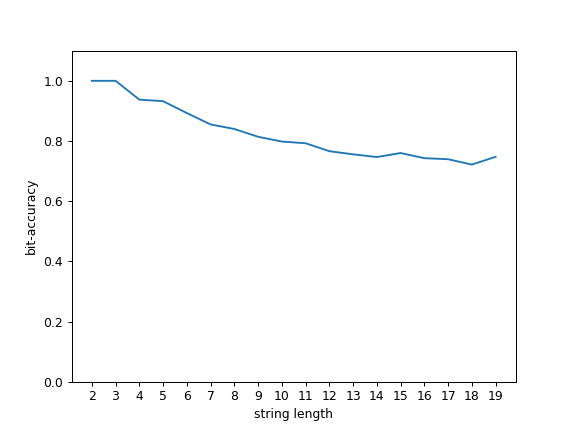

In [11]:
string_len = np.arange(2,20)
# set "verbose" to true to print out detailed information:
bit_accuracy = [test_by_length(l,verbose=True,n_samples=100) for l in string_len]
# plot the accuracy:
plt.plot(string_len,bit_accuracy)
plt.xlabel('string length'); plt.ylabel('bit-accuracy'); plt.xticks(string_len,string_len)
plt.ylim([0,1.1]); 


__Question 1:__ Recall that the model was trained on bit-strings of length 3. When tested on longer distances, the accuracy drops (check the plot above).

1. How does the state-size affect the accuracy for longer strings? Retrain the model with different state-sizes, specifically 50 and 100, and check how the accuracy for the longer strings is affected. Can you explain this trend?<br><br>

2. How does training on longer bit-sequences affect the generalization ability:
    * Train on 5 and 10 bit-strings, while keeping the state-size at 10. What do you observe?
    * Now, again train on bit-strings of length 5, but increase the state size to 100. What trend do you observe?
   

__Question 2:__ [Challenge question] In the current setup, the model predicts a single `score`, and uses the squared-loss. In the lectures we saw using training RNNs to predict output probabilities for each category (=2 in our case, one for 0, and one for 1), and using softmax followed by cross-entropy as the loss function:

Still, use affine (or linear) projection from hidden-state to output, but now regress to two "scores" (what should be dimensionality of `W_{hy}`?):

$$s_t = W_{hy}h_t + b_{hy}$$

This output now should converted to "probabilities" using `softmax`, and then errors should be back-propagated using the cross-entropy loss function:

$$y_t^i = \frac{\exp(s_t^i)}{\sum_{j=1}^{j=2} \exp(s_t^j)}$$

Note the "2" in the above equation is for 2 scores -- corresponding to 0 and 1 respectively.

The cross-entropy loss is:

$$\mathcal{L}_t(y_t,\tilde{y_t}) = - (1-\tilde{y_t})\log(y_t^1) - \tilde{y_t}\log(y_t^2) $$

where, $y_t$ are the predicted log-probabilties (or score above) and $\tilde{y_t}$ is the ground-truth target (i.e., either 0 or 1).

__Note__ : Make sure you understand how this equation corresponds to what you saw in the lecture.<br><br>


You might notice that the steps --- `softmax` followed by `cross-entropy` loss, first exponentiate and then take the log of the score. This is numerically unstable due to under/overflow (in the exponentiation). As this is a widely used operation, `PyTorch` combines these two steps in their [`nn.CrossEntropyLoss`](http://pytorch.org/docs/master/nn.html#crossentropyloss) function. So if we use this function, we do not have to explicitly use `softmax`.


__Part A__
1. Modify the model to predict two output probabilities -- for 0 and 1 respectively at each time-step.
2. Change the loss function from `nn.MSELoss` to `nn.CrossEntropyLoss`. Refer to the documentation of `nn.CrossEntropy` [here](http://pytorch.org/docs/master/nn.html#crossentropyloss).
3. Modify the "testing" code to get output from the model and verify that you are getting sensible outputs. 

__Part B__
1. In Q1 above, with the MSE loss, what was the minimum length of training bit-strings required to achieve perfect generalization?
2. What is the minimum length of training bit-strings required to achieve perferct generalization on longer test bit-string, when using the new model trained using the CrossEntropy loss function? Explain why / why not it is different.

Phew! That required some serious digging into PyTorch. But we are only getting started, marching on...
